# **BI-RADS classification pipeline for mammograms (images + metadata)**

#Introduction

The BI-RADS (Breast Imaging Reporting and Data System) classification based on mammograms is a complex problem in medical imaging. It involves predicting the BI-RADS category of a breast lesion on an image, which assesses the risk of malignancy (from BI-RADS 1 = normal to BI-RADS 5 = highly suspicious, or even 6 = proven cancer). To improve performance, we will integrate several types of data: not only the images themselves, but also clinical metadata such as breast density and radiographic view (CC or MLO).  We will detail a robust, production-ready pipeline including data preprocessing, class imbalance management, training of a multi-input deep learning model, and logging and backup of the trained model. The goal is to provide clear, well-explained step-by-step code to facilitate reproducibility and production deployment.

#I. Mounting Google Drive and accessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive"))

['Colab Notebooks', 'archive (1).zip', 'breast-level_annotations.csv', 'finding_annotations.csv', 'metadata.csv', 'SHA256SUMS.txt', 'opendatabenin.zip', 'Achitecture_open_Data']


In [ ]:
!unzip -q "/content/drive/MyDrive/archive (1).zip" -d "/content/data"

#**II**-verification of the contents of the extracted file

In [ ]:
import os
print(os.listdir("/content/data"))

['images_png']


In [ ]:
import os
print(os.listdir("/content/data/images_png"))

['f6c401dd715b995b9b4dba9a35c31908', '71d6a396da597fea31526ab02530d13d', '1655e8229f224faa520f598ed58fbfcf', 'af29c18e3b949d31b837843896c290b6', '4c48438f1aaf629400d60e573e4ce66c', '6aabb9235d0f82c68d466f86c9a0aa08', 'eff31eb110bc0a5d76f2db4c240dfd14', '2cd96b136024987ed4b7c239d4f13ead', 'b31ace4fc8a941dd0d6a79329c007198', 'dd43aacf90fa133baf01c0f2341b8a16', '175f10693af82fdf9bdf9e711697ec13', '8279f6a7292b1b62eddd47eee1bf2904', 'd955eb69b20823839ef6ceb6c2b5c8e9', 'd746c5e878799ec8f42e2e8f6ab9a992', '7c51789da6c462e55bcb95c2a7d437ee', '51c0018f897f071071d3d15bc3ba2f5d', '745e333246607d314064ede5923415bf', '9eae43df4b1f3eec2ac0506599a772d0', 'bb639e3af9d507ccb4a584be23bb9349', '926d757c9d974dbe06c8d5a619929880', '201095eaa1994a350f0ca83533a3b564', '8b477ee27be976426d02aed5a02b4e55', 'a363586a04ef07cd9e2387baf9fd4ee5', '12e8e75807da6433a348c4e23bc80705', 'd8ed2802a26e7f5755becfa0b1ce1f8f', '09b079d78e1f35e2a6919ac44dbf2a8e', '03d99a40835bb5f176c302296387af15', 'e728b8791952436211babd8f73

In [ ]:
exam_dir = "/content/data/images_png/5e6e6fdb4679697f74e3562e95fd2adb"
print(os.listdir(exam_dir))

['4de4c839a9256c08a92cca01a7059a3f.png', 'c73c3ae9487f603a9670c9ce9743b093.png', 'bf32f10ed2481ae28cdd342a8e37d586.png', '007b9ac3e2db01199be694b072f56e13.png']


# Download the annotation file breast-level_annotations.csv

In [ ]:
import pandas as pd

df_breast = pd.read_csv('/content/drive/MyDrive/breast-level_annotations.csv')
df_finding = pd.read_csv('/content/drive/MyDrive/finding_annotations.csv')
df_meta = pd.read_csv('/content/drive/MyDrive/metadata.csv')

print("breast-level_annotations:", df_breast.shape)
print(df_breast.head(2))
print("finding_annotations:", df_finding.shape)
print(df_finding.head(2))
print("metadata:", df_meta.shape)
print(df_meta.head(2))


breast-level_annotations: (20000, 10)
                           study_id                         series_id  \
0  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
1  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   

                           image_id laterality view_position  height  width  \
0  d8125545210c08e1b1793a5af6458ee2          L            CC    3518   2800   
1  290c658f4e75a3f83ec78a847414297c          L           MLO    3518   2800   

  breast_birads breast_density     split  
0     BI-RADS 2      DENSITY C  training  
1     BI-RADS 2      DENSITY C  training  
finding_annotations: (20486, 16)
                           study_id                         series_id  \
0  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   
1  48575a27b7c992427041a82fa750d3fa  26de4993fa6b8ae50a91c8baf49b92b0   

                           image_id laterality view_position  height  width  \
0  4e3a578fe535ea4f5258d3f7f4419db8        

# III- Prepares an image_path column that links each annotation to its PNG file

## Mapping PNG images ↔ annotations
**Image file structure**
The images are located in /content/data/images_png/<study_id>/<image_id>.png

In the CSV files, each image is identified by study_id and image_id

In [ ]:
# Base path where images are stored
base_img_path = "/content/data/images_png"

# Create an ‘image_path’ column for each annotation
df_breast['image_path'] = df_breast.apply(
    lambda row: f"{base_img_path}/{row['study_id']}/{row['image_id']}.png", axis=1
)

# Verify that the files exist (for the first 5 examples)
import os
print(df_breast[['image_path']].head())
print("Files found :")
print([os.path.exists(path) for path in df_breast['image_path'].head()])


                                          image_path
0  /content/data/images_png/b8d273e8601f348d36647...
1  /content/data/images_png/b8d273e8601f348d36647...
2  /content/data/images_png/b8d273e8601f348d36647...
3  /content/data/images_png/b8d273e8601f348d36647...
4  /content/data/images_png/8269f5971eaca3e5d3772...
Files found :
[True, True, True, True, True]


## IV- Cleaning labels (for training)

In [ ]:
print(df_breast['breast_density'].value_counts())

breast_density
DENSITY C    15292
DENSITY D     2700
DENSITY B     1908
DENSITY A      100
Name: count, dtype: int64


In [ ]:
print(df_breast['breast_birads'].value_counts())

breast_birads
BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: count, dtype: int64


In [ ]:
# Extraction of BI-RADS number (1,2,3,4,5) and density (A,B,C,D)
df_breast['birads'] = df_breast['breast_birads'].str.extract(r'(\d)').astype(int)
df_breast['density'] = df_breast['breast_density'].str.extract(r'DENSITY (\w)')

print(df_breast[['breast_birads','birads','breast_density','density']].head())

  breast_birads  birads breast_density density
0     BI-RADS 2       2      DENSITY C       C
1     BI-RADS 2       2      DENSITY C       C
2     BI-RADS 2       2      DENSITY C       C
3     BI-RADS 2       2      DENSITY C       C
4     BI-RADS 1       1      DENSITY C       C


In [ ]:
print(df_breast['density'].value_counts())
print(df_breast['birads'].value_counts())

density
C    15292
D     2700
B     1908
A      100
Name: count, dtype: int64
birads
1    13406
2     4676
3      930
4      762
5      226
Name: count, dtype: int64


## V- Structure inspection (split train/test)

In [ ]:
print(df_breast['split'].value_counts())

split
training    16000
test         4000
Name: count, dtype: int64


## VI- Exploratory data analysis                                            BI-RADS distribution

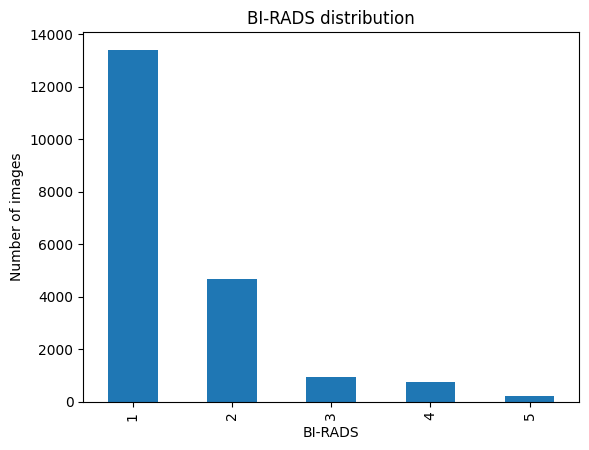

In [ ]:
import matplotlib.pyplot as plt

df_breast['birads'].value_counts().sort_index().plot(kind='bar')
plt.title("BI-RADS distribution")
plt.xlabel("BI-RADS")
plt.ylabel("Number of images")
plt.show()

We have five BI-RADS (Breast Imaging Reporting and Data System) classification classes in the entire dataset.(1,2,3,4,5)

# Breast density distribution

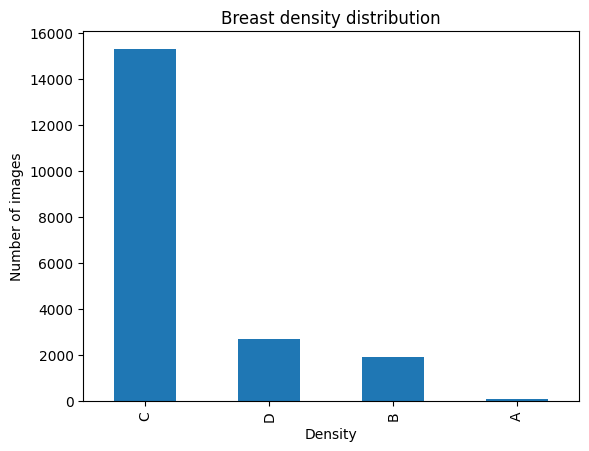

In [ ]:
df_breast['density'].value_counts().plot(kind='bar')
plt.title("Breast density distribution")
plt.xlabel("Density")
plt.ylabel("Number of images")
plt.show()

We have five breast density categories in the dataset.

# VII-  Exploration visuelle avancée des images et des metadata

## Display of multiple images with BI-RADS labels, density, view, age

In [ ]:
print(df_breast.columns.tolist())

['study_id', 'series_id', 'image_id', 'laterality', 'view_position', 'height', 'width', 'breast_birads', 'breast_density', 'split', 'image_path', 'birads', 'density']


In [ ]:
df_meta = pd.read_csv('/content/drive/MyDrive/metadata.csv')

# Mapping image_id → age
age_map = df_meta.set_index('SOP Instance UID')["Patient's Age"].to_dict()

def parse_age(age_str):
    try:
        return int(str(age_str).replace('Y',''))
    except:
        return None

df_breast['age'] = df_breast['image_id'].map(age_map).apply(parse_age)
print(df_breast[['image_id', 'age']].head())


                           image_id   age
0  d8125545210c08e1b1793a5af6458ee2  53.0
1  290c658f4e75a3f83ec78a847414297c  53.0
2  cd0fc7bc53ac632a11643ac4cc91002a  53.0
3  71638b1e853799f227492bfb08a01491  53.0
4  dd9ce3288c0773e006a294188aadba8e  42.0


In [ ]:
# Ensures that the columns exist
assert all(x in df_breast.columns for x in ['birads','density','view_position','age','image_path'])

# A varied sample is selected: 2 images per BI-RADS, prioritizing density/view diversity.
samples = []
for birads in sorted(df_breast['birads'].unique()):
    group = df_breast[df_breast['birads'] == birads]
    # Take two different densities if possible
    for density in group['density'].unique():
        subgroup = group[group['density'] == density]
        if not subgroup.empty:
            samples += subgroup.sample(min(1, len(subgroup)), random_state=42).to_dict('records')

print(f"Number of images selected : {len(samples)}")


Number of images selected : 19


 ## Displaying the grid

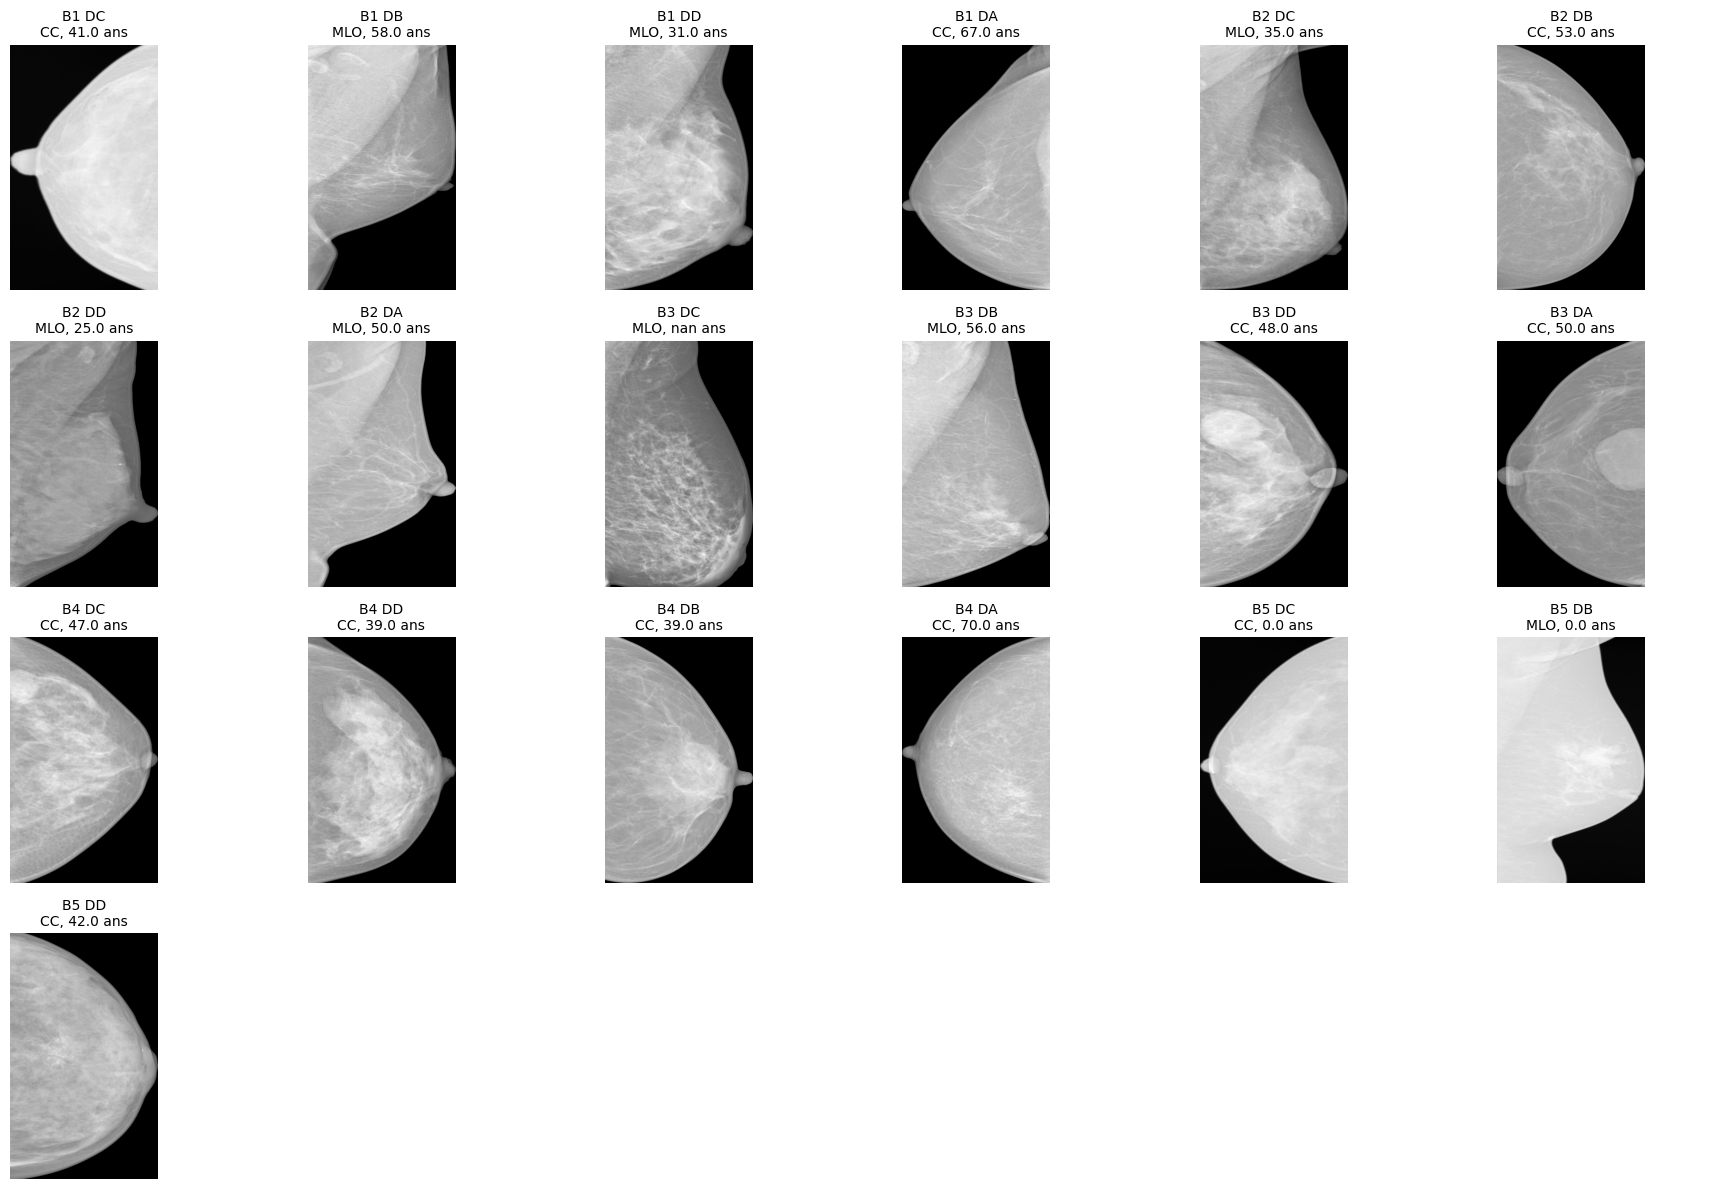

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

n = len(samples)
cols = min(n, 6)
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
if rows == 1:
    axes = [axes]
axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]

for ax, row in zip(axes, samples):
    try:
        img = Image.open(row['image_path'])
        age = row.get('age', 'NA')
        title = f"B{row['birads']} D{row['density']}\n{row['view_position']}, {age} ans"
        ax.imshow(img, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    except Exception as e:
        ax.set_visible(False)
        print(f"Erreur ouverture image : {row['image_path']} - {e}")

for ax in axes[len(samples):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

**Visual exploration of the dataset:**
The figure above illustrates the diversity of images in the VinDr-Mammo dataset, covering all BI-RADS categories (1 to 5), different breast densities (A to D), the two standard views (CC and MLO), and a wide range of ages. This diversity ensures that the clinical cases are representative for training and evaluating deep learning models. The images are of good quality and consistency, and contain all the information needed for a multi-modality approach. A few outliers in age (“0 years,” “NaN”) will be filtered out during data preparation to avoid introducing noise into the model.

# Training a model based solely on the images contained in the dataset

## Cleaning & Splits

In [ ]:
df = df_breast.dropna(subset=['image_path','birads'])
train_df = df[df['split']=='training']
test_df  = df[df['split']=='test']
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.1,
                                    stratify=train_df['birads'], random_state=42)

## Creation of image generators

## Convert the birads column to a string

In [ ]:
# 1. Transforme birads dans le df principal en object
df_breast['birads'] = df_breast['birads'].astype('object')

# 2. Création des splits
df = df_breast.dropna(subset=['image_path','birads']).copy()
train_df = df[df['split']=='training'].copy()
val_df   = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(val_df.index).copy()
test_df  = df[df['split']=='test'].copy()

# 3. Assignation safe vers string
train_df.loc[:, 'birads'] = train_df['birads'].astype(str)
val_df.loc[:, 'birads']   = val_df['birads'].astype(str)
test_df.loc[:, 'birads']  = test_df['birads'].astype(str)

## Complete pipeline: training with augmentation and focal loss

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, layers
from PIL import Image

# --- 0) Nettoyage : détection et suppression des images corrompues ---
def scan_and_remove_corrupt(df, path_col='image_path'):
    bad = []
    for path in df[path_col].tolist():
        try:
            with Image.open(path) as img:
                img.verify()
        except (IOError, OSError, SyntaxError):
            bad.append(path)
    return bad

bad_train = scan_and_remove_corrupt(train_df)
bad_val   = scan_and_remove_corrupt(val_df)
bad_test  = scan_and_remove_corrupt(test_df)

print(f"Images corrompues détectées — train: {len(bad_train)}, val: {len(bad_val)}, test: {len(bad_test)}")

# On filtre maintenant les DataFrames
train_df = train_df[~train_df['image_path'].isin(bad_train)].copy()
val_df   = val_df[~val_df['image_path'].isin(bad_val)].copy()
test_df  = test_df[~test_df['image_path'].isin(bad_test)].copy()

# --- 1) Définition de `classes` correctement avant les générateurs ---
classes = sorted(train_df['birads'].unique())
classes = [str(c) for c in classes]
print("Classes utilisées :", classes)

# --- 2) Data augmentation et préparation des générateurs ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    shear_range=5,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='birads',
    classes=classes,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='birads',
    classes=classes,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
test_gen = val_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='birads',
    classes=classes,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# --- 3) Définition de la focal loss multi-classes ---
from tensorflow.keras.losses import CategoricalFocalCrossentropy
loss_fn = CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)

# --- 4) Construction du modèle CNN basé sur ResNet50 ---
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# --- 5) Callbacks pour sauvegarde et early stopping ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_focal_model_clean.h5', save_best_only=True)
]

# --- 6) Entraînement du modèle ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# --- 7) Évaluation et métriques finales ---
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)

from sklearn.metrics import classification_report, confusion_matrix

y_true = np.array(test_df['birads'].astype(int)) - 1
y_pred = np.argmax(model.predict(test_gen), axis=1)
print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Images corrompues détectées — train: 0, val: 0, test: 0
Classes utilisées : ['1', '2', '3', '4', '5']
Found 14400 validated image filenames belonging to 5 classes.
Found 1600 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.6253 - loss: 0.1434

450/450 ━━━━━━━━━━━━━━━━━━━━ 452s 970ms/step - accuracy: 0.6253 - loss: 0.1434 - val_accuracy: 0.6700 - val_loss: 0.1191
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6666 - loss: 0.1215

450/450 ━━━━━━━━━━━━━━━━━━━━ 430s 955ms/step - accuracy: 0.6666 - loss: 0.1215 - val_accuracy: 0.6700 - val_loss: 0.1188
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 396s 881ms/step - accuracy: 0.6685 - loss: 0.1223 - val_accuracy: 0.6700 - val_loss: 0.1188
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 419s 931ms/step - accuracy: 0.6721 - loss: 0.1194 - val_accuracy: 0.6700 - val_loss: 0.1195
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 415s 922ms/step - accuracy: 0.6707 - loss: 0.1175 - val_accuracy: 0.6700 - val_loss: 0.1192
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 536ms/step - accuracy: 0.6834 - loss: 0.1094
Test accuracy: 0.6704999804496765
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 537ms/step
              precision    recall  f1-score   support

           1       0.67      1.00      0.80      2682
           2       0.00      0.00      0.00       934
           3       0.00      0.00      0.00       186
           4       0.00      0.00      0.00       152
           5       0.00      0.00      0.00        46

 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

# Added code to define dataframes
# 1. Transforme birads dans le df principal en object
df_breast['birads'] = df_breast['birads'].astype('object')

# 2. Création des splits
df = df_breast.dropna(subset=['image_path','birads']).copy()
train_df = df[df['split']=='training'].copy()
val_df   = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(val_df.index).copy()
test_df  = df[df['split']=='test'].copy()

# 3. Assignation safe vers string
train_df.loc[:, 'birads'] = train_df['birads'].astype(str)
val_df.loc[:, 'birads']   = val_df['birads'].astype(str)
test_df.loc[:, 'birads']  = test_df['birads'].astype(str)

# 4. Define classes
classes = sorted(train_df['birads'].unique())
classes = [str(c) for c in classes]


# --- 1) Data augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    shear_range=5,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='image_path', y_col='birads',
    target_size=(224,224),
    color_mode='rgb', class_mode='categorical', # Changed to categorical
    batch_size=32, shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='image_path', y_col='birads',
    target_size=(224,224),
    color_mode='rgb', class_mode='categorical', # Changed to categorical
    batch_size=32, shuffle=False
)
test_gen = val_datagen.flow_from_dataframe(
    test_df, x_col='image_path', y_col='birads',
    target_size=(224,224),
    color_mode='rgb', class_mode='categorical', # Changed to categorical
    batch_size=32, shuffle=False
)

# --- 2) Focal loss multi-classes ---
loss_fn = CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)

# --- 3) Modèle CNN (ResNet50 base) ---
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# --- 4) Callbacks ---
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_focal_model.h5', save_best_only=True)
]

# --- 5) Entraînement ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# --- 6) Évaluation & métriques ---
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)

from sklearn.metrics import classification_report, confusion_matrix

#y_true = np.array(test_df['birads'].astype(int)) - 1 # This line is no longer needed with categorical
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Get the true labels from the generator
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Found 14400 validated image filenames belonging to 5 classes.
Found 1600 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.6379 - loss: 0.1343

450/450 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - accuracy: 0.6380 - loss: 0.1343 - val_accuracy: 0.6700 - val_loss: 0.1210
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.6665 - loss: 0.1233

450/450 ━━━━━━━━━━━━━━━━━━━━ 466s 989ms/step - accuracy: 0.6665 - loss: 0.1233 - val_accuracy: 0.6700 - val_loss: 0.1187
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 434s 965ms/step - accuracy: 0.6753 - loss: 0.1203 - val_accuracy: 0.6700 - val_loss: 0.1212
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6682 - loss: 0.1186

450/450 ━━━━━━━━━━━━━━━━━━━━ 427s 950ms/step - accuracy: 0.6682 - loss: 0.1186 - val_accuracy: 0.6700 - val_loss: 0.1186
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.6697 - loss: 0.1162

450/450 ━━━━━━━━━━━━━━━━━━━━ 428s 952ms/step - accuracy: 0.6697 - loss: 0.1162 - val_accuracy: 0.6700 - val_loss: 0.1183
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 454s 978ms/step - accuracy: 0.6673 - loss: 0.1193 - val_accuracy: 0.6700 - val_loss: 0.1188
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 425s 945ms/step - accuracy: 0.6688 - loss: 0.1172 - val_accuracy: 0.6700 - val_loss: 0.1185
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 420s 933ms/step - accuracy: 0.6685 - loss: 0.1166 - val_accuracy: 0.6700 - val_loss: 0.1186
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.6834 - loss: 0.1091
Test accuracy: 0.6704999804496765
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 571ms/step
              precision    recall  f1-score   support

           1       0.67      1.00      0.80      2682
           2       0.00      0.00      0.00       934
           3       0.00      0.00      0.00       186
           4       0.00      0.00      0.00       152
           5       0.00      0.00      0.00        46

 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 0) Préparation des splits (rappel)
import pandas as pd, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

df = df_breast.dropna(subset=['image_path','birads']).copy()
train_df = df[df['split']=='training'].copy()
val_df   = train_df.sample(frac=0.1, random_state=42)
train_df = train_df.drop(val_df.index).copy()
test_df  = df[df['split']=='test'].copy()

for d in (train_df, val_df, test_df):
    d['birads'] = d['birads'].astype(str)

# 1) Oversampling : équilibrer le train au niveau de la classe majoritaire
rng = 42
counts = train_df['birads'].value_counts().sort_index()
target = counts.max()
parts = []
for cls, g in train_df.groupby('birads'):
    parts.append(g.sample(n=target, replace=True, random_state=rng))
train_df_balanced = pd.concat(parts).sample(frac=1.0, random_state=rng).reset_index(drop=True)

print("Répartition train (avant) :", counts.to_dict())
print("Répartition train (après) :", train_df_balanced['birads'].value_counts().sort_index().to_dict())

# 2) Alpha vectoriel (Class-Balanced Loss via “Effective Number of Samples”) — Cui et al. (CVPR’19)
#    alpha_c = (1 - β) / (1 - β^n_c), normalisé
beta = 0.999   # 0.99–0.9999 selon la taille; 0.999 marche bien ici
classes = sorted(train_df_balanced['birads'].unique(), key=int)   # ['1','2','3','4','5']
n = np.array([(train_df_balanced['birads']==c).sum() for c in classes], dtype=np.float64)
alpha_vec = (1 - beta) / (1 - np.power(beta, n))
alpha_vec = alpha_vec / alpha_vec.sum()
print("alpha_vec :", dict(zip(classes, np.round(alpha_vec, 4))))

# 3) Générateurs équilibrés (on entraîne sur train_df_balanced)
img_size = (448, 448)   # ↑ résolution pour détails mammo
bs = 16                 # batch plus petit si VRAM limitée

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05, height_shift_range=0.05,
    zoom_range=0.1, brightness_range=(0.95, 1.05),
    shear_range=3, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df_balanced, x_col='image_path', y_col='birads',
    classes=classes, target_size=img_size, color_mode='rgb',
    class_mode='categorical', batch_size=bs, shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='image_path', y_col='birads',
    classes=classes, target_size=img_size, color_mode='rgb',
    class_mode='categorical', batch_size=bs, shuffle=False
)
test_gen = val_datagen.flow_from_dataframe(
    test_df, x_col='image_path', y_col='birads',
    classes=classes, target_size=img_size, color_mode='rgb',
    class_mode='categorical', batch_size=bs, shuffle=False
)

# 4) (Optionnel mais recommandé) Mixup simple sur le générateur train
def mixup_batch(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(x.shape[0])
    x_mix = lam * x + (1-lam) * x[idx]
    y_mix = lam * y + (1-lam) * y[idx]
    return x_mix, y_mix

class MixupSequence(tf.keras.utils.Sequence):
    def __init__(self, base_gen, alpha=0.4):
        self.base = base_gen; self.alpha = alpha
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        return mixup_batch(x, y, self.alpha)

train_gen_mix = MixupSequence(train_gen, alpha=0.4)  # active mixup (ICLR’18) — utile en long-tailed
# (CutMix est aussi possible; Mixup suffit pour démarrer)

# 5) Modèle : ResNet50 gelé, puis fine-tuning sur le dernier stage
base = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base.input, outputs=out)

# Focal loss (multi-classe) avec alpha vectoriel (Keras >= 2.13)
from tensorflow.keras.losses import CategoricalFocalCrossentropy
loss_fn = CategoricalFocalCrossentropy(alpha=alpha_vec, gamma=2.0)  # alpha en vecteur

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=loss_fn, metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_cb_focal.keras', save_best_only=True, monitor='val_loss')
]

# 6) Entraînement (avec Mixup)
history = model.fit(
    train_gen_mix,
    validation_data=val_gen,
    epochs=12,
    callbacks=callbacks
)

# 7) Fine-tuning : on dégèle le dernier bloc conv5*
for lyr in base.layers:
    lyr.trainable = ('conv5' in lyr.name)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=loss_fn, metrics=['accuracy'])
history_ft = model.fit(
    train_gen_mix, validation_data=val_gen, epochs=6, callbacks=callbacks
)

# 8) Évaluation avec métriques adaptées à l’imbalance
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, average_precision_score
from sklearn.preprocessing import label_binarize

proba  = model.predict(test_gen)
y_pred = proba.argmax(axis=1)
y_true = test_gen.classes  # indices alignés avec test_gen.class_indices
idx2lab = {v:k for k,v in test_gen.class_indices.items()}
labs_order = [idx2lab[i] for i in range(len(idx2lab))]

print("Balanced accuracy :", balanced_accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=labs_order))

# PR-AUC (un-vs-rest) — plus pertinent en déséquilibre
y_true_ovr = label_binarize(y_true, classes=list(range(len(labs_order))))
ap = [average_precision_score(y_true_ovr[:,i], proba[:,i]) for i in range(len(labs_order))]
print("AP par classe :", dict(zip(labs_order, np.round(ap,3))))
print("AP macro :", float(np.mean(ap)))

Répartition train (avant) : {'1': 9652, '2': 3383, '3': 660, '4': 540, '5': 165}
Répartition train (après) : {'1': 9652, '2': 9652, '3': 9652, '4': 9652, '5': 9652}
alpha_vec : {'1': np.float64(0.2), '2': np.float64(0.2), '3': np.float64(0.2), '4': np.float64(0.2), '5': np.float64(0.2)}
Found 48260 validated image filenames belonging to 5 classes.
Found 1600 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 3469s 1s/step - accuracy: 0.2026 - loss: 0.2250 - val_accuracy: 0.0525 - val_loss: 0.2062
Epoch 2/12
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 3405s 1s/step - accuracy: 0.1980 - loss: 0.2061 - val_accuracy: 0.0437 - val_loss: 0.2053
Epoch 3/12
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 3395s 1s/step - accuracy: 0.1975 - loss: 0.2061 - val_accuracy: 0.0437 - val_loss: 0.2050
Epoch 4/12
3017/3017 ━━━━━━━━━━━━━━━━━━━━ 3419s 1s/step - accuracy: 0.1996 - loss: 0.2060 - val_accuracy: 0.2244 - val_loss: 0.2088
Epoch 5/12
1603/3017 ━━━━━━━━━━━━━━━━━━━━ 26:12 1s/step - accuracy: 0.1895 - loss: 0.2061